### Visualización geoespacial de municipios y puntos de mallado en España

Este código carga datos de municipios, construye un mapa geográfico de la Península con la población en escala logarítmica y superpone los puntos del mallado sobre un mapa base, permitiendo verificar visualmente su distribución espacial.

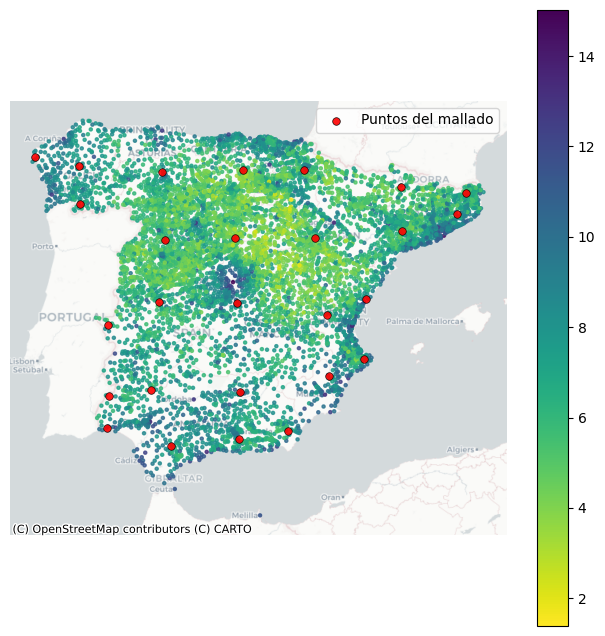

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx


# Ruta y lectura
ruta = "MUNICIPIOS.csv"
df = pd.read_csv(
    ruta,
    sep=";",            # separador
    encoding="latin1",  # mejor opción para tildes y eñes
    low_memory=False    # tipado más estable
)

df = df.replace(",", ".", regex=True)
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except Exception:
        pass

# Crear GeoDataFrame de municipios
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["LONGITUD_ETRS89"], df["LATITUD_ETRS89"]),
    crs="EPSG:4326"
)

# Excluir provincias de Canarias y Baleares
islas = ["Las Palmas", "Santa Cruz de Tenerife", "Illes Balears"]
gdf = gdf[~gdf["PROVINCIA"].isin(islas)]

# Filtrar Península
gdf = gdf[
    (gdf["LONGITUD_ETRS89"] > -10) & (gdf["LONGITUD_ETRS89"] < 5) &
    (gdf["LATITUD_ETRS89"] > 35) & (gdf["LATITUD_ETRS89"] < 44)
]

# Convertir a proyección métrica
gdf = gdf.to_crs(epsg=3857)

# Escala logarítmica de población
gdf["POBLACION_LOG"] = np.log1p(gdf["POBLACION_MUNI"])

# Graficar municipios
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(
    ax=ax,
    column="POBLACION_LOG",
    cmap="viridis_r",
    markersize=5,
    alpha=0.8,
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

#  Añadir puntos del mallado
pts = pd.read_csv("mallado.csv", sep=None, engine="python", encoding="latin1")

# Crear GeoDataFrame
gdf_pts = gpd.GeoDataFrame(
    pts.dropna(subset=["lon", "lat"]),
    geometry=gpd.points_from_xy(pts["lon"], pts["lat"]),
    crs="EPSG:4326"
)

# Cargar el polígono de España (desde Natural Earth)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
espania = world[world["NAME"] == "Spain"].to_crs(epsg=3857)

# Convertir los puntos al mismo CRS
gdf_pts = gdf_pts.to_crs(epsg=3857)

# Pintar los puntos
gdf_pts.plot(ax=ax, color="red", markersize=30, marker="o",
             edgecolor="black", linewidth=0.5, alpha=0.9, label="Puntos del mallado")

ax.legend()
ax.set_axis_off()
plt.show()




### Inspección de la estructura y tipos de datos del DataFrame

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8132 entries, 0 to 8131
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   COD_INE            8132 non-null   int64  
 1   ID_REL             8132 non-null   int64  
 2   COD_GEO            8132 non-null   int64  
 3   COD_PROV           8132 non-null   int64  
 4   PROVINCIA          8132 non-null   object 
 5   NOMBRE_ACTUAL      8132 non-null   object 
 6   POBLACION_MUNI     8132 non-null   int64  
 7   SUPERFICIE         8132 non-null   float64
 8   PERIMETRO          8132 non-null   int64  
 9   COD_INE_CAPITAL    8132 non-null   int64  
 10  CAPITAL            8132 non-null   object 
 11  POBLACION_CAPITAL  8132 non-null   int64  
 12  HOJA_MTN25_ETRS89  8132 non-null   object 
 13  LONGITUD_ETRS89    8132 non-null   float64
 14  LATITUD_ETRS89     8132 non-null   float64
 15  ORIGENCOOR         8132 non-null   object 
 16  ALTITUD            8132 

### Revisión de la estructura y tipos de datos del DataFrame de puntos

In [6]:
pts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   poblacion_total  27 non-null     int64  
 1   lat              27 non-null     float64
 2   lon              27 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 780.0 bytes
